# Business Analytics :
### Zvartnots Data Manipulation
Group: Meri Asatryan, Lili Kostanyan, Jeni Balaban

The dataset under consideration has been meticulously curated by scraping information from the Zvartnots International Airport website, providing a comprehensive repository of flight-related data. This dataset offers a wealth of insights that can be harnessed for sophisticated business analytics projects.

Key variables, including flight numbers, destinations, and delays, present opportunities for in-depth analysis. Furthermore, an intricate analysis based on temporal factors, such as weekdays versus weekends, offers the potential to uncover patterns in traveler behavior. 

In [5]:
import pandas as pd
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from pandas.plotting import table
from statsmodels.tsa.arima_model import ARIMA # ARIMA model
from statsmodels.tsa.stattools import acf, pacf #ACF and PACF, which are later explained
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from pylab import rcParams
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")


In [6]:
flights = pd.read_csv('flights_data.csv')
country_dataset = pd.read_csv('worldcities.csv')
print(flights.head)
print(country_dataset.head)

<bound method NDFrame.head of            Destination FlightNumber Code         Scheduled     Delay
0             Istanbul       3F 476  IST  2023/10/16 14:30  Departed
1                Milan       3F 246  MXP  2023/10/16 22:20  Departed
2                Aktau       DV 845  SCO  2023/10/16 22:45  Departed
3      Mineralnye Vody      WZ 4331  MRV  2023/10/16 22:50  Departed
4               Moscow      SU 1868  SVO  2023/10/16 23:15  Departed
...                ...          ...  ...               ...       ...
11190  Mineralnye Vody      A4 6032  MRV  2023/12/05 22:20    Ontime
11191            Milan      W4 5568  MXP  2023/12/05 22:25    Ontime
11192          Larnaca       CY 415  LCA  2023/12/05 22:35    Ontime
11193        Abu Dhabi      5W 7188  AUH  2023/12/05 22:35    Ontime
11194          Larnaca      W6 4550  LCA  2023/12/05 23:25    Ontime

[11195 rows x 5 columns]>
<bound method NDFrame.head of               city   city_ascii      lat       lng    country iso2 iso3  \
0         

# Data Cleaning

We have two datasets flights data and countries dataset. Here we need to merge this two datasets for future analysis. We add longitude, latitude and country to our flights data from countries data for each destination of flights (city).There are some cities that are not included in our countries datset that´s why we add them manually. 

In [7]:
country_dataset = country_dataset[country_dataset['country'] != 'United States']
columns_to_drop = ['iso2', 'iso3', 'admin_name', 'capital', 'population', 'id', "city", "city_ascii","iso2", "iso3" ]
merged_data =country_dataset.drop(columns=columns_to_drop)

merged_data = pd.merge(flights, country_dataset, left_on='Destination', right_on='city', how='left')
merged_data = merged_data.fillna("NA")


city_country_mapping = {
    "Aktau" : {'country': "Kazakhstan",  'lat': 43.6588 , 'lng': 51.1975},
    'St.Petersburg': {'country': 'Russia', 'lat': 59.9343, 'lng': 30.3351},
    'Mineralnye Vody': {'country': 'Russia', 'lat': 44.2095, 'lng': 43.1053},
    'Nizhny Novgorod': {'country': 'Russia', 'lat': 56.3159, 'lng': 43.9944},
    'Kishinev': {'country': 'Moldova', 'lat': 47.0105, 'lng': 28.8638},
    'Sharm El Sheikh': {'country': 'Egypt', 'lat': 27.9158, 'lng': 34.3297},
    'Zurich': {'country': 'Switzerland', 'lat': 47.3769, 'lng': 8.5417}
}

for city, mapping in city_country_mapping.items():
    mask = merged_data['Destination'] == city
    merged_data.loc[mask, 'country'] = mapping['country']
    merged_data.loc[mask, 'lat'] = mapping['lat']
    merged_data.loc[mask, 'lng'] = mapping['lng']

# Replace remaining NaN values with "NA"
merged_data = merged_data.fillna("NA")
columns_to_drop = ['iso2', 'iso3', 'admin_name', 'capital', 'population', 'id', "city", "city_ascii","iso2", "iso3" ]
merged_data = merged_data.drop(columns=columns_to_drop)
# Print the merged data
print(merged_data)
merged_data.to_csv('merged_data.csv', index=False)

           Destination FlightNumber Code         Scheduled     Delay      lat  \
0             Istanbul       3F 476  IST  2023/10/16 14:30  Departed  41.0136   
1                Milan       3F 246  MXP  2023/10/16 22:20  Departed  45.4669   
2                Aktau       DV 845  SCO  2023/10/16 22:45  Departed  43.6588   
3      Mineralnye Vody      WZ 4331  MRV  2023/10/16 22:50  Departed  44.2095   
4               Moscow      SU 1868  SVO  2023/10/16 23:15  Departed  55.7558   
...                ...          ...  ...               ...       ...      ...   
11225  Mineralnye Vody      A4 6032  MRV  2023/12/05 22:20    Ontime  44.2095   
11226            Milan      W4 5568  MXP  2023/12/05 22:25    Ontime  45.4669   
11227          Larnaca       CY 415  LCA  2023/12/05 22:35    Ontime  34.9167   
11228        Abu Dhabi      5W 7188  AUH  2023/12/05 22:35    Ontime  24.4667   
11229          Larnaca      W6 4550  LCA  2023/12/05 23:25    Ontime  34.9167   

           lng             

In our flights data we have a column called Scheduled that keeps the date and time of the flights. Here we divide it into to columns Date and Time.

In [8]:
merged_data['Scheduled'] = pd.to_datetime(merged_data['Scheduled'])

# Extract date and time components into separate columns
merged_data['Date'] = merged_data['Scheduled'].dt.date
merged_data['Time'] = merged_data['Scheduled'].dt.time
merged_data = merged_data.drop(columns="Scheduled")


unique_flight_codes = merged_data['FlightNumber'].str[:2].unique()



In this part, we take the two characters of the flight number, which indicates the airline that completes the flight, and based on that we add a new column called Airline and insert the Airline names.

In [9]:
merged_data['FlightNumberDigits'] = merged_data['FlightNumber'].str[:2]

# Map the airline names based on the first two digits of the flight number
airline_mapping = {
    'JI': 'Armenian Airlines',
    '3F': 'Fly One',
    'G6': 'Fly Arna',
    '6A': 'Armenia Airways',
    '5G': 'Shirak Avia',
    '5W': 'Wizz Air',
    'UT': 'Utair',
    'PG': 'Pegasus Airlines',
    'DV': 'Scat Airlines',
    'WZ': 'Red WIngs', 
    'SU': 'Aeroflot', 
    'QR': 'Qatar Airways', 
    'PC': 'Pegasus Airlines', 
    'LO': 'LOT Polish Airlines',
    'A3': 'Aegean Airlines',
    'OS': 'Austrian Airlines',
    'LH': 'Lufthansa',
    'UA': 'United Airlines',
    'SM': 'Air Cairo',
    'UA': 'United Airlines',
    'ME': 'Middle East Airlines',
    'UA': 'United Airlines',
    'FV': 'Rossiya airlines JSC',
    'G9': 'Air Arabia',
    'FZ': 'Flydubai',
    'CY': 'Cyprus Airways',
    'A4': 'Azimuth',
    'AX': 'Trans States Airlines',
    'NG': 'Lauda Air',
    'AX': 'Trans States Airlines',
    'CA': 'Air China',
    'BR': 'EVA Air', 
    'TO': 'Transavia',
    'W6': 'Wizz Air',
    'W4': 'Wizz Air',
    'EN': 'Enter Air',
    'BT': 'AirBaltic',
    'AM': 'AMC Airlines',
    'AF': 'Air France',
    'DE': 'Condor',
    'FV': 'Rossiya Airlines',
    'DL': 'Delta Airlines',
    'FT': 'Fly Egypt',
    'B2': 'Belavia',
    'SN': 'Brussels Airlines',
    '8D': 'FitsAir',
    'EW': 'Eurowings',
    'IR': 'Iran Airtour',

    


}

# Add a new column 'AirlineName' based on the mapping
merged_data['Airline'] = merged_data['FlightNumberDigits'].map(airline_mapping).fillna('Charter Flight')
merged_data.drop(columns='FlightNumberDigits', inplace=True)
merged_data.to_csv('merged_data.csv', index=False)

In this part, we add a categorical column Armenian which shows if the airline is Armenian or International, if it is 1 than it is Armenian, otherwise its international. Also, we add a column that shows the day of the week based on date for future analysis. 

In [10]:
armenian_airlines = ['Armenian Airlines', 'Fly One', 'Fly Arna', 'Armenia Airways', 'Shirak Avia']

# Add a new column 'ArmenianOrInternational' based on Armenian airlines
merged_data['Armenian'] = merged_data['Airline'].apply(lambda x: 1 if x in armenian_airlines else 0)

if not pd.api.types.is_datetime64_any_dtype(merged_data['Date']):
    try:
        merged_data['Date'] = pd.to_datetime(merged_data['Date'])
    except ValueError as e:
        print(f"Error: {e}")

# Add a new column 'DayOfWeek' based on the day of the week
merged_data['DayOfWeek'] = merged_data['Date'].dt.day_name()
merged_data['Status'] = merged_data['Delay'].replace('Departed', 'Onetime')
merged_data.drop(columns= "Delay", inplace=True)
merged_data = merged_data[merged_data['Date'] != '2023-10-16']
print(merged_data)
merged_data.to_csv('merged_data.csv', index=False)

           Destination FlightNumber Code      lat      lng  \
6               Moscow       3F 312  DME  55.7558  37.6178   
7                 Doha       QR 285  DOH  25.2867  51.5333   
8               Moscow       JI 103  SVO  55.7558  37.6178   
9               Moscow       G6 396  VKO  55.7558  37.6178   
10              Moscow       UT 785  VKO  55.7558  37.6178   
...                ...          ...  ...      ...      ...   
11225  Mineralnye Vody      A4 6032  MRV  44.2095  43.1053   
11226            Milan      W4 5568  MXP  45.4669     9.19   
11227          Larnaca       CY 415  LCA  34.9167  33.6333   
11228        Abu Dhabi      5W 7188  AUH  24.4667  54.3667   
11229          Larnaca      W6 4550  LCA  34.9167  33.6333   

                    country       Date      Time            Airline  Armenian  \
6                    Russia 2023-10-17  00:30:00            Fly One         1   
7                     Qatar 2023-10-17  00:50:00      Qatar Airways         0   
8           

In this part we drop the duplicated values as we do the data scraping two times a day some rows are being repeated. Also, there are some cases that during our scraping some of the flights are being in the process of Boarding, so we drop that rows, and keep the ones that are already finished. Furthermore, there are cases when three different companies sell tickets for the same flight, thats why if we havce the same destination and exaclty thr same date and time for several rows we keep only one. 

In [11]:
num_duplicates_before = merged_data.duplicated().sum()
print(f"Number of duplicate rows before: {num_duplicates_before}")
merged_data = merged_data.drop_duplicates()
merged_data = merged_data[merged_data['Status'] != 'Boarding']
merged_data = merged_data.drop_duplicates(subset=['Destination', 'Date', 'Time'])
merged_data.to_csv('merged_data.csv', index=False)

# Replace 'onetime' with 'OnTime' in the 'Status' column
merged_data['Status'] = merged_data['Status'].replace('Onetime', 'Ontime')
merged_data['Status'] = merged_data['Status'].replace('21.11.23', 'Cancelled')
merged_data['Status'] = merged_data['Status'].replace('03.12.23', 'Cancelled')


Number of duplicate rows before: 2391


# Analysis

In this part we are analyzing the flight data and determining which destinations are most popular, based on the number of flights going to each destination. The threshold is used to filter out less frequently visited destinations.

In [12]:
df = merged_data

threshold = 50

# 1. Identifing Popular Destinations
popular_destinations = df['Destination'].value_counts()
significant_destinations = popular_destinations[popular_destinations > threshold]
print("Popular Destinations with Significant Number of Flights:")
print(significant_destinations)

Popular Destinations with Significant Number of Flights:
Destination
Moscow             1311
Sochi               298
Mineralnye Vody     248
Larnaca             206
St.Petersburg       198
Tehran              176
Abu Dhabi           165
Kishinev            157
Doha                150
Sharm El Sheikh     138
Vienna              136
Dubai               118
Paris               112
Rome                100
Istanbul             89
Frankfurt            87
Milan                85
Sharjah              84
Athens               71
Warsaw               68
Yekaterinburg        66
Samara               64
Tbilisi              64
Name: count, dtype: int64


Here we are identifing countries with a significant number of flights, where "significant" is defined as having more than the specified threshold number of flights (in this case, 50). We calculate the frequency of flights to each country, filtered it to include only those countries with flight counts exceeding the threshold, and then printed a list of these significant countries along with their respective flight counts.

In [13]:
# 3. Evaluating Frequency of Flights to Specific Countries
country_counts = df['country'].value_counts()
significant_countries = country_counts[country_counts > threshold]
print("\nCountries with Significant Number of Flights:")
print(significant_countries)


Countries with Significant Number of Flights:
country
Russia                  2464
United Arab Emirates     367
Italy                    227
Cyprus                   206
Iran                     176
Moldova                  157
Qatar                    150
Egypt                    138
Austria                  136
Germany                  119
France                   116
Turkey                    99
Georgia                   93
Greece                    71
Poland                    68
Name: count, dtype: int64


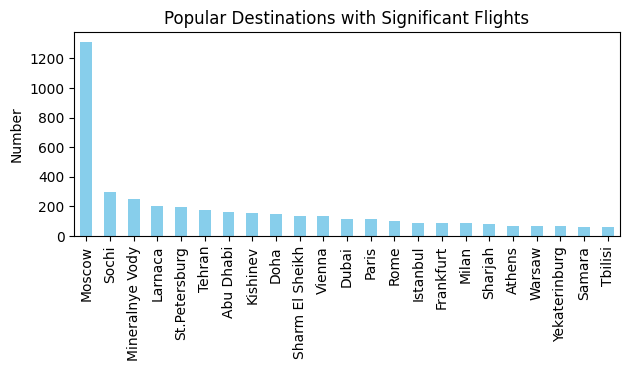

In [14]:
# Plotting for better visualization
plt.figure(figsize=(12, 6))

# Bar chart for Popular Destinations
plt.subplot(2, 2, 1)
significant_destinations.plot(kind='bar', color='skyblue')
plt.title('Popular Destinations with Significant Flights')
plt.xlabel('')
plt.ylabel('Number')

plt.tight_layout()
plt.show()

The bar chart visually presents the popular destinations with a significant number of flights. It shows 'Moscow' as the most frequented destination with significantly more flights than other listed cities. Following Moscow, there is a steep decline in flight numbers, with 'Sochi' being the second most served destination. 'Tbilisi' being the last may be connected that it is colse to Armenia and many people go there by car.

Now we calculate the number of flights operated by each airline. Additionally, we compute the on-time performance count for each airline, which shows the proportion of flights that were on time for each airline.

In [15]:
flights_per_airline = merged_data['Airline'].value_counts()
ontime_performance = merged_data.groupby('Airline')['Status'].apply(lambda x: (x == 'Ontime').sum() / len(x) * 100)
print(flights_per_airline)

Airline
Fly One                  709
Wizz Air                 632
Aeroflot                 449
Azimuth                  332
Red WIngs                298
Rossiya Airlines         285
Armenian Airlines        247
Fly Arna                 241
Shirak Avia              163
Qatar Airways            150
Utair                    141
Charter Flight           117
Flydubai                 116
Air Arabia                84
Armenia Airways           74
Aegean Airlines           71
Austrian Airlines         68
LOT Polish Airlines       68
Lufthansa                 67
Pegasus Airlines          60
AMC Airlines              46
Belavia                   41
Cyprus Airways            36
Transavia                 36
Air Cairo                 34
Air France                32
Fly Egypt                 28
Iran Airtour              28
Scat Airlines             26
Brussels Airlines         20
Condor                    20
Delta Airlines            20
Middle East Airlines      20
FitsAir                   14
Eurowi

Here we calculate the frequency of flights for each day of the week from a dataset.

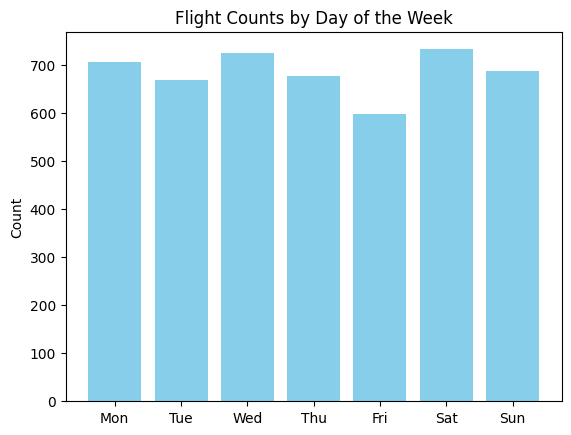

In [16]:
day_of_week_counts = merged_data['DayOfWeek'].value_counts()
day_of_week_counts = merged_data['DayOfWeek'].value_counts().sort_index()
weekday_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

plt.bar(weekday_names, day_of_week_counts, color =  "skyblue")
plt.xlabel('')
plt.ylabel('Count')
plt.title('Flight Counts by Day of the Week')
plt.show()

And then we visualize this data using a bar chart. The bar chart presents flight counts for each day of the week, with Wednesday having the highest and Tuesday the lowest, though the variation across the week is minimal, indicating a relatively consistent number of flights per day.

Here we calculate the on-time performance percentage for each airline in the dataset. It determines the proportion of flights that were on time for each airline and expresses this as a percentage, providing a measure of each airline's punctuality.

In [17]:
# On-Time Performance (Percentage of On-Time Flights) for Each Airline
on_time_counts = df[df['Status'] == 'Ontime']['Airline'].value_counts()
on_time_percentages = (on_time_counts / flights_per_airline) * 100
print("\nOn-Time Performance for Each Airline (Percentage):")
print(on_time_percentages)


On-Time Performance for Each Airline (Percentage):
Airline
AMC Airlines              97.826087
Aegean Airlines           97.183099
Aeroflot                  96.881960
Air Arabia                97.619048
Air Cairo                100.000000
Air China                100.000000
Air France               100.000000
AirBaltic                100.000000
Armenia Airways          100.000000
Armenian Airlines         96.761134
Austrian Airlines        100.000000
Azimuth                   96.987952
Belavia                  100.000000
Brussels Airlines        100.000000
Charter Flight            98.290598
Condor                   100.000000
Cyprus Airways           100.000000
Delta Airlines           100.000000
EVA Air                  100.000000
Enter Air                100.000000
Eurowings                100.000000
FitsAir                   92.857143
Fly Arna                  97.510373
Fly Egypt                 96.428571
Fly One                   97.461213
Flydubai                  96.551724
Iran

Here we calculate the delay performance percentage for each airline.

In [18]:
delay_counts = df[df['Status'] == 'Delay']['Airline'].value_counts()
delay_percentages = (delay_counts / flights_per_airline) * 100
print("\nOn-Time Performance for Each Airline (Percentage):")
print(delay_percentages)


On-Time Performance for Each Airline (Percentage):
Airline
AMC Airlines             2.173913
Aegean Airlines          1.408451
Aeroflot                 1.336303
Air Arabia               1.190476
Air Cairo                     NaN
Air China                     NaN
Air France                    NaN
AirBaltic                     NaN
Armenia Airways               NaN
Armenian Airlines        2.429150
Austrian Airlines             NaN
Azimuth                  1.807229
Belavia                       NaN
Brussels Airlines             NaN
Charter Flight           0.854701
Condor                        NaN
Cyprus Airways                NaN
Delta Airlines                NaN
EVA Air                       NaN
Enter Air                     NaN
Eurowings                     NaN
FitsAir                  7.142857
Fly Arna                 0.414938
Fly Egypt                3.571429
Fly One                  0.987306
Flydubai                 2.586207
Iran Airtour                  NaN
LOT Polish Airlines   

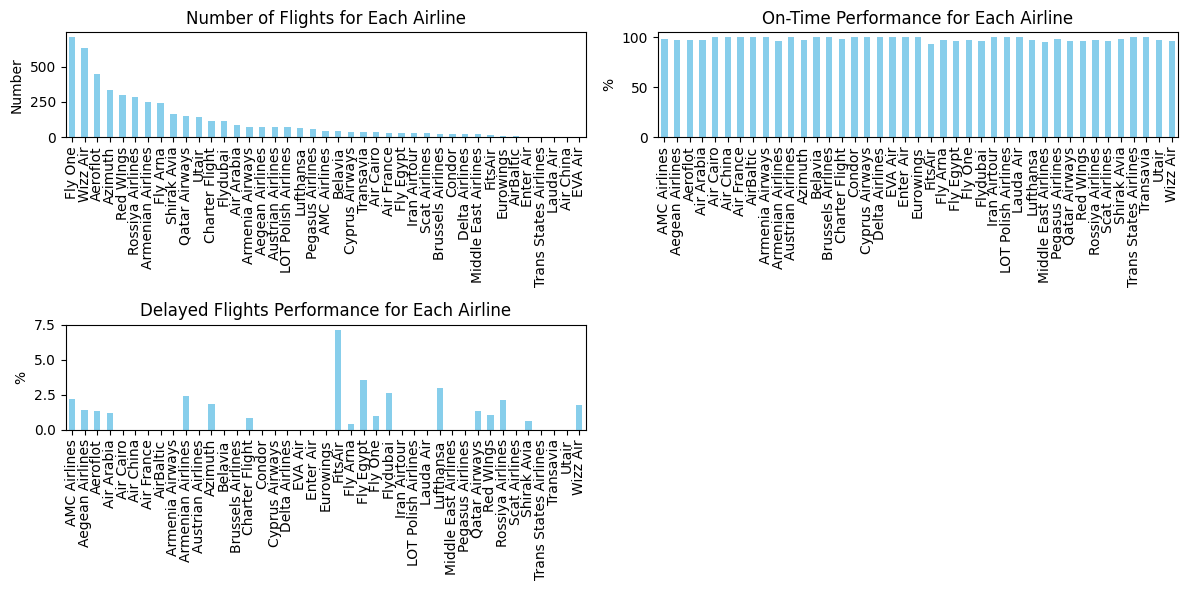

In [19]:
# Plotting for better visualization
plt.figure(figsize=(12, 6))

# Bar chart for Number of Flights for Each Airline
plt.subplot(2, 2, 1)
flights_per_airline.plot(kind='bar', color='skyblue')
plt.title('Number of Flights for Each Airline')
plt.xlabel('')
plt.ylabel('Number')

# Bar chart for On-Time Performance for Each Airline
plt.subplot(2, 2, 2)
on_time_percentages.plot(kind='bar', color='skyblue')
plt.title('On-Time Performance for Each Airline')
plt.xlabel('')
plt.ylabel('%')

# Bar chart for Percentage of Delayed Flights for Each Airline
plt.subplot(2, 2, 3)
delay_percentages.plot(kind='bar', color='skyblue')
plt.title('Delayed Flights Performance for Each Airline')
plt.xlabel('')
plt.ylabel('%')

plt.tight_layout()
plt.show()

The bar chart displays the total number of flights, on-time performance, and the percentage of delayed flights for each airline. Each one is presented in a separate subplot, providing a clear overview of airline operations and punctuality.
'FlyOne' has the most number of flights. From the On-Time preformance we can see that 'FitsAir' has the lowest % and also has the highest % of Delayed flights

Here we calculate the distribution of different flight statuses (like 'Ontime', 'Delayed', etc.) in our dataset.

In [20]:
flight_status_distribution = df['Status'].value_counts()
print("Distribution of Flight Status:")
print(flight_status_distribution)

Distribution of Flight Status:
Status
Ontime               4672
Delay                  60
Cancelled              52
Earlier                12
Contacttheairline       2
Name: count, dtype: int64


Now we create a summary table showing the frequency of different flight statuses for each airline in the dataset.

Count of Each Flight Status for Each Airline:
Status                 Cancelled  Contacttheairline  Delay  Earlier  Ontime
Airline                                                                    
AMC Airlines                   0                  0      1        0      45
Aegean Airlines                1                  0      1        0      69
Aeroflot                       4                  0      6        4     435
Air Arabia                     1                  0      1        0      82
Air Cairo                      0                  0      0        0      34
Air China                      0                  0      0        0       2
Air France                     0                  0      0        0      32
AirBaltic                      0                  0      0        0       6
Armenia Airways                0                  0      0        0      74
Armenian Airlines              2                  0      6        0     239
Austrian Airlines              0          

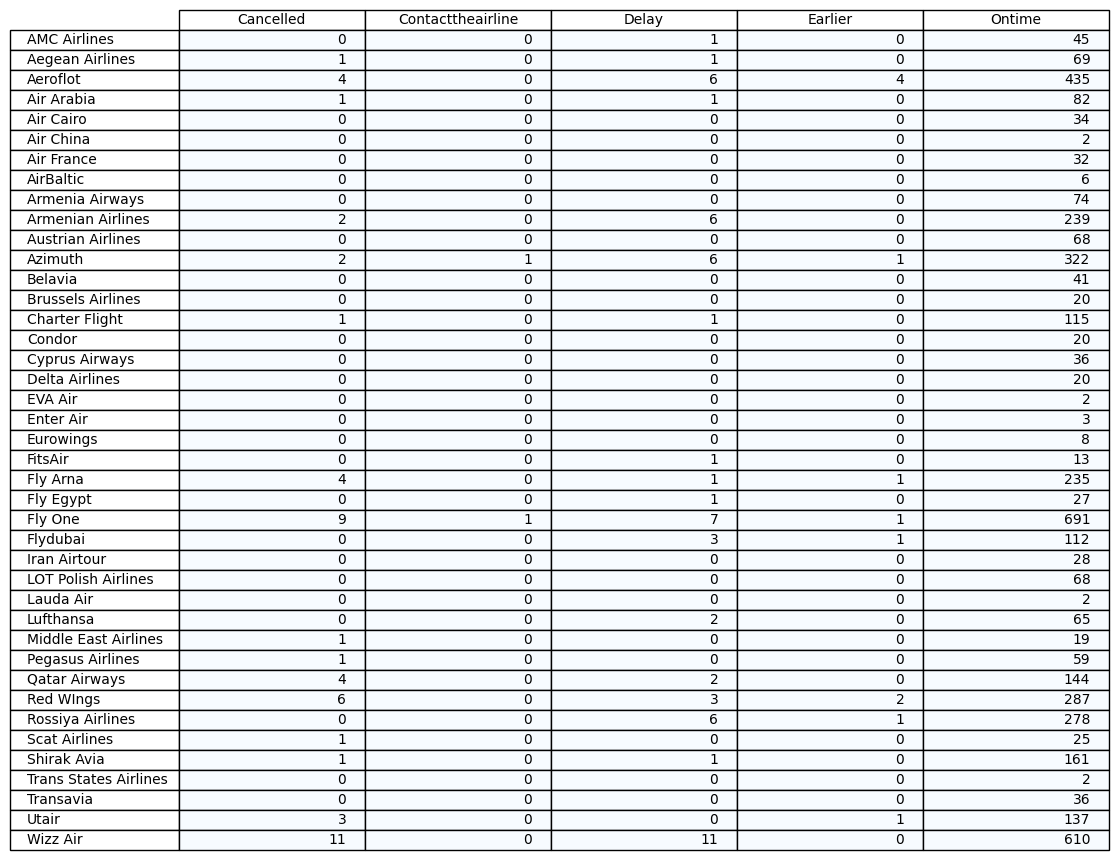

In [21]:
flight_status_counts = pd.crosstab(df['Airline'], df['Status'])
print("Count of Each Flight Status for Each Airline:")
print(flight_status_counts)


# Plotting the table
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figure size as needed

# Hide the axes
ax.axis('off')
cmap = plt.get_cmap("Blues")
# Creating the table
tab = table(ax, flight_status_counts, loc='center', colWidths=[0.2] * len(df['Status'].unique()),
            cellColours=cmap(np.full_like(flight_status_counts, 0.8)))

# Styling the table
tab.auto_set_font_size(False)
tab.set_fontsize(10)
tab.scale(1.2, 1.2)

# Show the plot
plt.show()

We analyze the distribution of flight frequencies across different times of the day in the dataset, identifying peak hours based on the number of flights.

In [22]:
time_series_analysis = merged_data.groupby('Date')['FlightNumber'].count()
peak_hours = merged_data.groupby('Time')['FlightNumber'].count()
print(peak_hours)

Time
00:05:00    13
00:15:00    60
00:20:00    12
00:25:00    18
00:30:00    13
            ..
23:35:00    17
23:40:00    19
23:45:00    20
23:50:00    42
23:55:00     4
Name: FlightNumber, Length: 255, dtype: int64


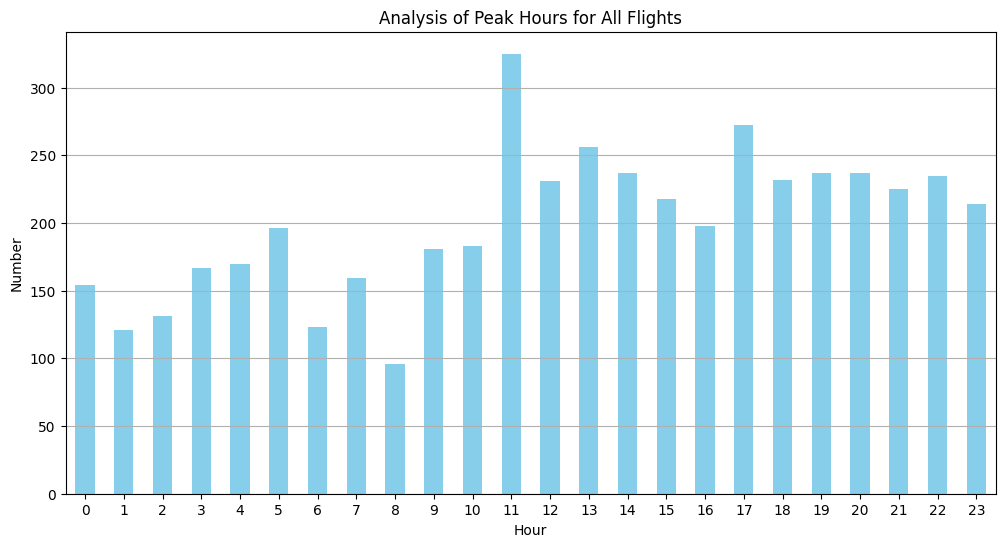

In [23]:
merged_data['Hour'] = pd.to_datetime(merged_data['Time'].astype(str)).dt.hour
delayed_flights = merged_data[merged_data['Status'] == "Delay"]
# Peak hours analysis for all flights
peak_hours = merged_data.groupby('Hour')['FlightNumber'].count()
peak_hours_delay = delayed_flights.groupby('Hour')['FlightNumber'].count()
# Plotting peak hours analysis
plt.figure(figsize=(12, 6))
peak_hours.plot(kind='bar', color='skyblue')
plt.title('Analysis of Peak Hours for All Flights')
plt.xlabel('Hour')
plt.ylabel('Number')
plt.xticks(rotation=0)  # Adjust rotation based on your preference
plt.grid(axis='y')
plt.show()

The bar chart visualizes flight frequency by hour, with the tallest red bar at 11th hour indicating a peak in flight activity, second peak is on 17th hour and the lowest on 8th one. The plot shows that the early afternoon and after are the busiest time for flights. 

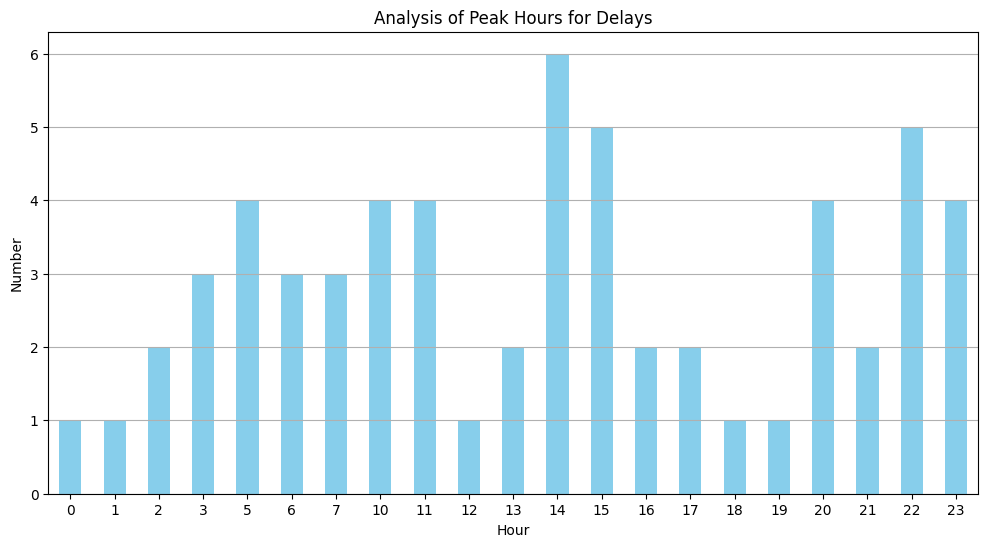

In [24]:
plt.figure(figsize=(12, 6))
peak_hours_delay.plot(kind='bar', color='skyblue')
plt.title('Analysis of Peak Hours for Delays')
plt.xlabel('Hour')
plt.ylabel('Number')
plt.xticks(rotation=0)  # Adjust rotation based on your preference
plt.grid(axis='y')
plt.show()

The Bar chart visualizes the distribution of flights across different hours of the day, highlighting peak hours in the dataset.
The bar chart indicates that flight delays at 12th, 18th and 19th hours, with notably fewer delays. The chart provides a clear visual of the times when delays are most common like 14th hour.

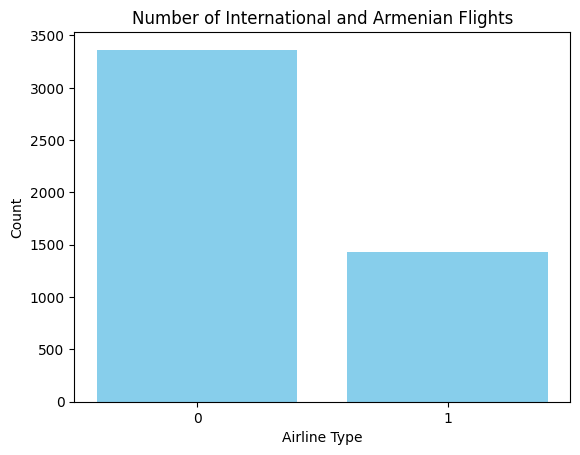

In [25]:
#Ploting the number of flights for armenian and international airlines
airline_type_counts = merged_data['Armenian'].value_counts().sort_index()

plt.bar(airline_type_counts.index.astype(str), airline_type_counts, color = "skyblue")
plt.xlabel('Airline Type')
plt.ylabel('Count')
plt.title('Number of International and Armenian Flights')
plt.show()

The bar chart visualizes the count of flights by Armenian and International airlines, with '0' representing international and '1' for Armenian, showing a higher number of International flights compared to Armenian ones.

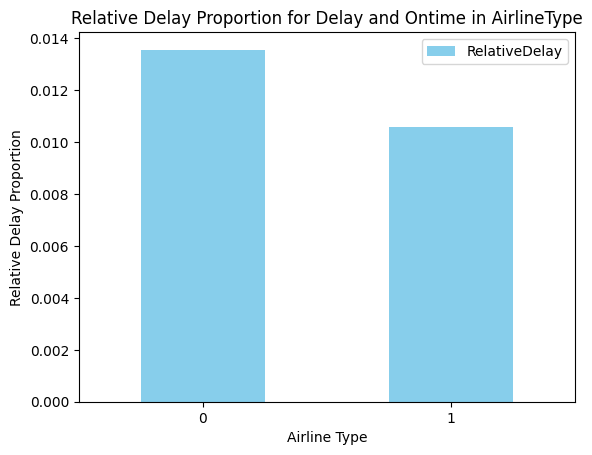

In [26]:
# Calculate relative delay proportions for 'Status'
delay_proportions = merged_data.groupby(['Armenian', 'Status']).size().reset_index(name='Count') \
    .pivot(index='Armenian', columns='Status', values='Count') \
    .assign(RelativeDelay=lambda x: x['Delay'] / (x['Delay'] + x['Ontime']))

# Create a bar plot for the relative delays based on 'Status'
delay_proportions.plot(kind='bar', y='RelativeDelay', color="skyblue", title='Relative Delay Proportion for Delay and Ontime in AirlineType')
plt.xlabel('Airline Type')
plt.ylabel('Relative Delay Proportion')
plt.xticks(rotation=0)
plt.show()    

The bar chart compares the proportion of delays between two airline types, with '0' indicating International airlines and '1' representing Armenian airlines. The chart shows International airlines with a higher relative delay proportion compared to Armenian airlines.

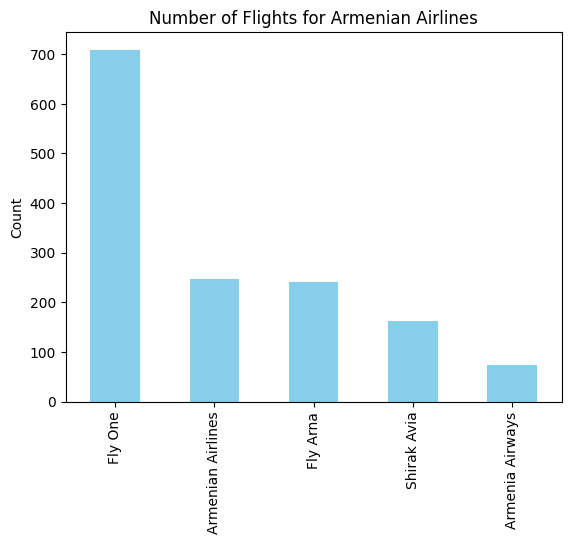

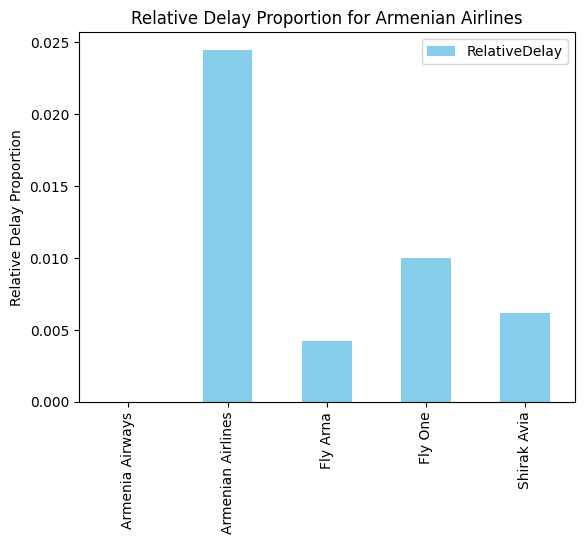

In [27]:
armenian_data = merged_data[merged_data['Armenian'] == 1]

# Create a bar plot for the number of flights for each Armenian airline
armenian_data['Airline'].value_counts().plot(kind='bar', color= "skyblue")
plt.title('Number of Flights for Armenian Airlines')
plt.xlabel('')
plt.ylabel('Count')
plt.show()

# Calculate relative delay proportions for Armenian airlines
delay_proportions_armenian = armenian_data.groupby(['Airline', 'Status']).size().reset_index(name='Count') \
    .pivot(index='Airline', columns='Status', values='Count') \
    .assign(RelativeDelay=lambda x: x['Delay'] / (x['Delay'] + x['Ontime']))

# Create a bar plot for relative delays for Armenian airlines
delay_proportions_armenian.plot(kind='bar', y='RelativeDelay', color="skyblue")
plt.title('Relative Delay Proportion for Armenian Airlines')
plt.xlabel('')
plt.ylabel('Relative Delay Proportion')
plt.show()

The first chart displays the total number of flights per each Armenian airline, and the second chart shows the proportion of flights that were delayed for each airline. These help to see the operational volume and punctuality among Armenian airlines. And previous two plots that were discussed are showing that results because there are only 5 Armenian airlines.

# Time series analysis 

<a id='section1'></a>
### *Checking stationarity*

Here we combine the separate 'Date' and 'Time' columns into a single datetime column and we set this as the new index for the dataset.

In [28]:
merged_data['Date'] = merged_data['Date'].astype(str)
merged_data['Time'] = merged_data['Time'].astype(str)

merged_data['DateTime'] = pd.to_datetime(merged_data['Date'] + ' ' + merged_data['Time'])

merged_data.set_index('DateTime', inplace=True)


In [29]:
# Resample the data to count the number of flights per day
daily_flights = merged_data.resample('D').size()
daily_flights.head(10).reset_index(name='Flights')

,DateTime,Flights
0,2023-10-17,109
1,2023-10-18,115
2,2023-10-19,104
3,2023-10-20,120
4,2023-10-21,114
5,2023-10-22,122
6,2023-10-23,116
7,2023-10-24,115
8,2023-10-25,113
9,2023-10-26,102


Let's now plot the data and understand visually, whether there is a Trend/Seasonality or not.

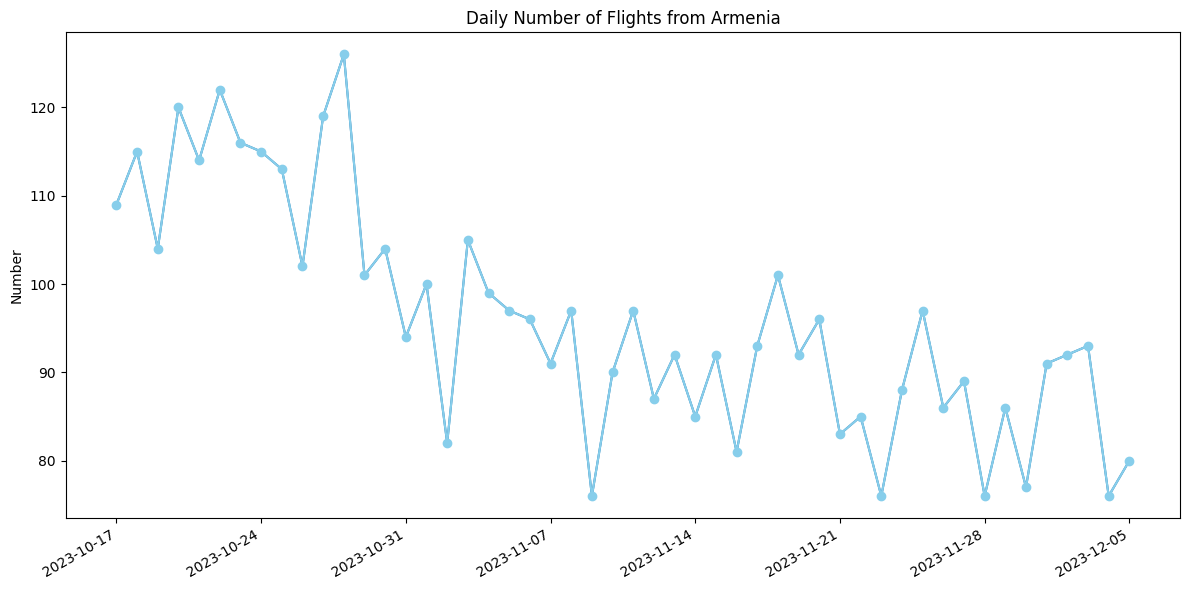

In [30]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(daily_flights)
daily_flights.plot(kind='line', color='skyblue', marker='o')
plt.title('Daily Number of Flights from Armenia')
plt.xlabel('')
plt.ylabel('Number')
plt.xticks()

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.show()

The line graph that provides a visual interpretation of the fluctuation in the daily number of flights from Armenia over a certain period. Each data point representing the number of flights on a given day is marked with a blue circle, and the points are connected by a blue line, showing the trend of the data over time. It displays one-week intervals, which helps in identifying weekly patterns or trends in the flight data, such as increases or decreases in flight frequency on specific days of the week.

Here we conduct a seasonal decomposition of a time series dataset to separate it into trend, seasonal, and residual components. Then we create a series of plots to visually show these components next to the original data.

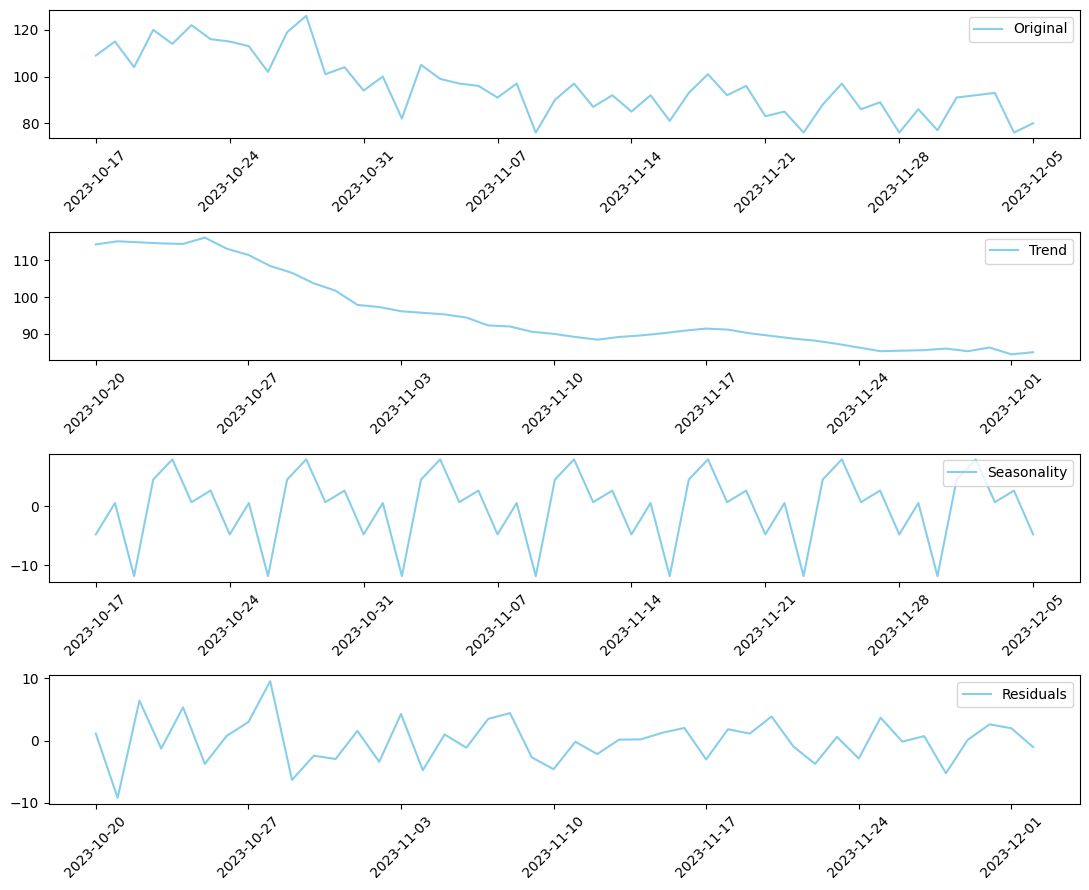

In [31]:
# Seasonal Decomposition using the 'additive' model
decomposition = sm.tsa.seasonal_decompose(daily_flights, model='additive')

# Extracting the trend, seasonal, and residual components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plots
rcParams['figure.figsize'] = 11, 9

plt.subplot(411)
plt.plot(daily_flights, color='skyblue', label='Original')
plt.legend(loc='best')
plt.xticks(rotation=45)  
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.subplot(412)
plt.plot(trend, color='skyblue', label='Trend')
plt.legend(loc='best')
plt.xticks(rotation=45)  
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.subplot(413)
plt.plot(seasonal, color='skyblue', label='Seasonality')
plt.legend(loc='upper right')
plt.xticks(rotation=45) 
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 

plt.subplot(414)
plt.plot(residual, color='skyblue', label='Residuals')
plt.legend(loc='best')
plt.xticks(rotation=45)  
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.show()

Original - this graph represents the actual data of daily flights. It shows the raw flight numbers without any modification.

Trend - this graph shows the long-term progression or direction of the data, smoothing out short-term fluctuations and revealing decreasing movement over time.

Seasonality - this graph indicates the repeating short-term cycle within the data. It demonstrates fluctuations that occur at regular intervals, such as weekly.

Residuals - this graph shows the residuals, which are the differences between the actual data and the model fitted by combining the trend and seasonal components. It represents the randomness or irregularities in the data that are not explained by the trend and seasonality.And it is clearly random.

Here we calculate the moving average of a time series dataset and we plot it alongside the original data.

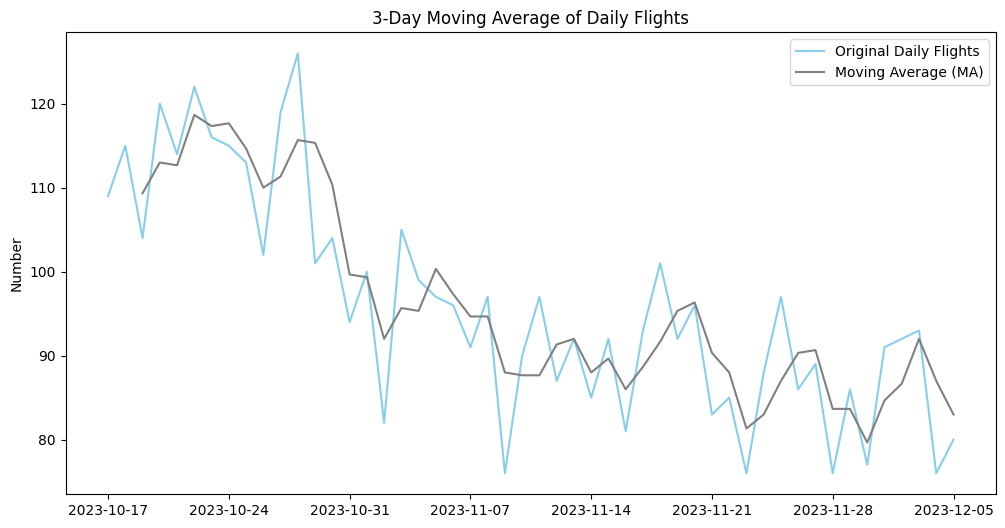

In [32]:
# Calculate the moving average
window_size = 3
rolmean = daily_flights.rolling(window=3).mean()

# Plots
plt.figure(figsize=(12, 6))
plt.plot(daily_flights, color='skyblue', label='Original Daily Flights')
plt.plot(rolmean, color='gray', label='Moving Average (MA)')
plt.title(f'{window_size}-Day Moving Average of Daily Flights')
plt.xlabel('')
plt.ylabel('Number')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.show()

The graph compares the actual number of daily flights with a 3-day moving average trend. The original daily flights are shown in blue, depicting the real data with all its fluctuations. The moving average, shown in gray, smooths out these fluctuations to highlight underlying trends in the data over a short-term, 3-day period. This moving average line helps to identify the direction in which the data is moving, making it easier to spot increases or decreases in flight numbers without being misled by the daily variability. The x-axis represents the date, and the y-axis represents the number of flights. The dates on the x-axis are spaced at weekly intervals for clarity.

Here we calculate and plot an exponentially weighted moving average (EWMA).

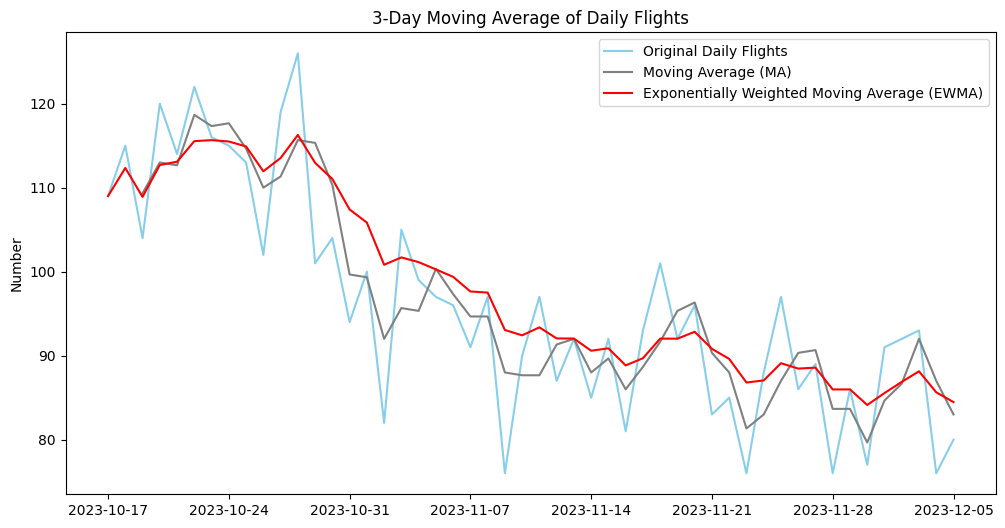

In [33]:
# ewma method from Pandas library to calculate exponentially weighted MA
exp_smooth = daily_flights.ewm(halflife=3).mean()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(daily_flights, color='skyblue', label='Original Daily Flights')
plt.plot(rolmean, color='gray', label='Moving Average (MA)')
plt.plot(exp_smooth, color='red', label='Exponentially Weighted Moving Average (EWMA)')
plt.title(f'{window_size}-Day Moving Average of Daily Flights')
plt.xlabel('')
plt.ylabel('Number')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.show()

The graph shows the actual daily flight numbers alongside two smoothed trends - a 3-day simple moving average and an exponentially weighted moving average. The actual data is in blue, the simple moving average is in gray, and the exponentially weighted average is in red, with the averages providing a clearer view of underlying trends and recent changes in flight patterns. We see that EWMA is usually upper than MA. 

However, the MA provides better fitting, it still underestimates the Trend. Generally, MA always underestimates whenever there is an increaseing trend, and overestimates in the decreasing trend case.

### *Substructing average*
<a id='section3'></a>

In [34]:
# create new DataFrame, which presents the difference between actual data and rolling mean values
daily_flights_diff = daily_flights - rolmean
# view the first 12 observations to ensure missing values were dropped
daily_flights_diff.head(12).reset_index(name='Flights')

,DateTime,Flights
0,2023-10-17,NaN
1,2023-10-18,NaN
2,2023-10-19,-5.333333
3,2023-10-20,7.000000
4,2023-10-21,1.333333
5,2023-10-22,3.333333
6,2023-10-23,-1.333333
7,2023-10-24,-2.666667
8,2023-10-25,-1.666667
9,2023-10-26,-8.000000


The table above shows, that we have missing values for the first 10 observations in the *new* dataset. This missing values are generated, because moving average was estimated using window=3 parameter, which calculates an average of each 3 days. For simplicity, we will drop those missing values from the dataset. 

In [35]:
daily_flights_diff.dropna(inplace=True)
# view the first 12 observations to ensure missing values were dropped
daily_flights_diff.head(10).reset_index(name='Flights')

,DateTime,Flights
0,2023-10-19,-5.333333
1,2023-10-20,7.000000
2,2023-10-21,1.333333
3,2023-10-22,3.333333
4,2023-10-23,-1.333333
5,2023-10-24,-2.666667
6,2023-10-25,-1.666667
7,2023-10-26,-8.000000
8,2023-10-27,7.666667
9,2023-10-28,10.333333


Now, we have a new dataset (hopefully de-trended), we can apply both techniques (MA and EWMA) again and observe the results.

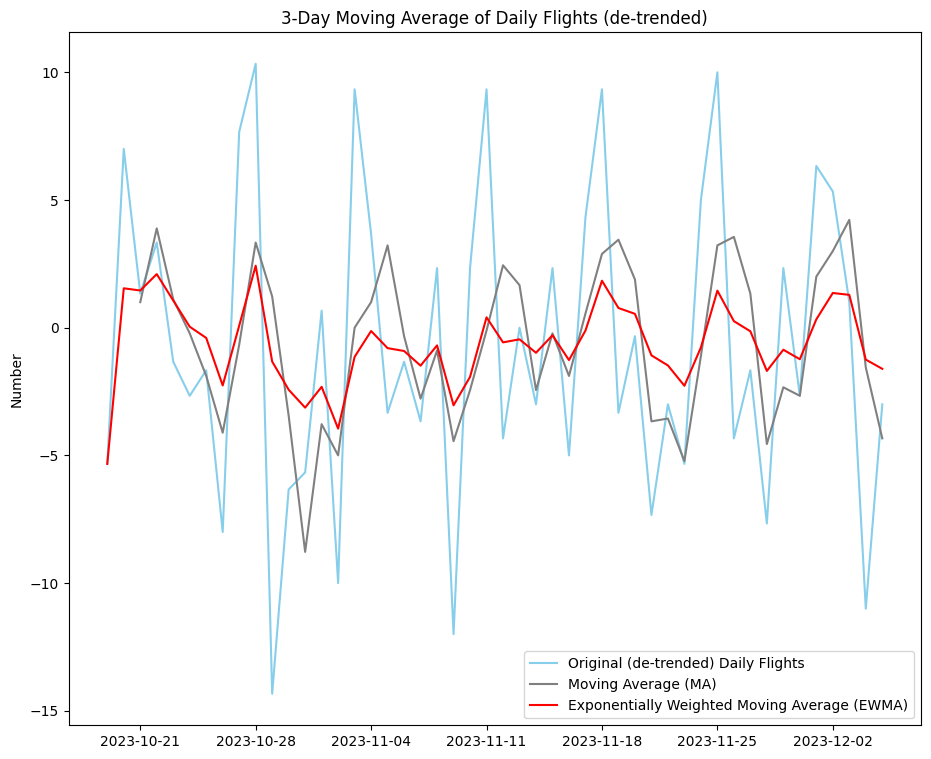

In [36]:
# estimating MA for the new dataset
ma_diff = daily_flights_diff.rolling(window=3).mean()
# estimating EWMA for the new dataset
exp_diff = daily_flights_diff.ewm(halflife=3).mean()
# plotting our new dataset
plt.plot(daily_flights_diff, color='skyblue', label='Original (de-trended) Daily Flights')
# plotting MA 
plt.plot(ma_diff, color='gray', label='Moving Average (MA)')
# plotting EWMA
plt.plot(exp_diff, color='red', label='Exponentially Weighted Moving Average (EWMA)')
plt.title(f'{window_size}-Day Moving Average of Daily Flights (de-trended)')
plt.xlabel('')
plt.ylabel('Number')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.show()

Here we have de-tranded data and we see that here MA is upper than EWMA and MA preforms better.

### Differencing using lagged values

Let's use another approach to de-trending. For this method we will substract from our data its <b> lagged </b> values. More specifically, for any given time period t, we will calculate Value(t) - Value(t-1). As a consequence, the new dataset will have a missing value for the first observation (as there is no preceeding time period for the first observation).

In [37]:
# creating new dataset based on the difference between actual and lagged values
daily_flights_lagged = daily_flights - daily_flights.shift()
daily_flights_lagged.head(10).reset_index(name='Flights')

,DateTime,Flights
0,2023-10-17,NaN
1,2023-10-18,6.0
2,2023-10-19,-11.0
3,2023-10-20,16.0
4,2023-10-21,-6.0
5,2023-10-22,8.0
6,2023-10-23,-6.0
7,2023-10-24,-1.0
8,2023-10-25,-2.0
9,2023-10-26,-11.0


Here we calculate and plot both simple and exponential weighted moving averages for a time series dataset then we compare these with the original data. This visual comparison helps us in analyzing trends and patterns in the dataset.

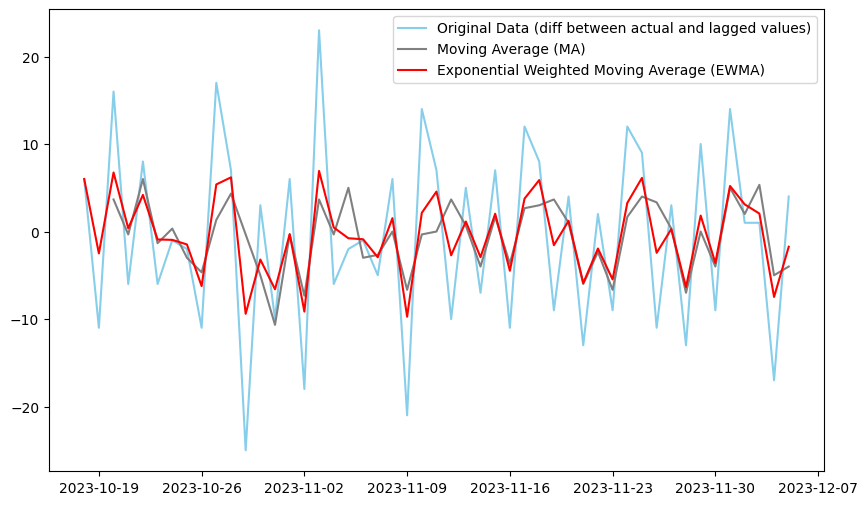

In [38]:
# Estimating MA for the new dataset
ma_lagged = daily_flights_lagged.rolling(window=3).mean()
# Estimating EWMA for the new dataset
exp_lagged = daily_flights_lagged.ewm(span=3, adjust=False).mean()
# Plotting the original dataset
plt.figure(figsize=(10, 6))
plt.plot(daily_flights_lagged, color='skyblue', label='Original Data (diff between actual and lagged values)')
# Plotting MA 
plt.plot(ma_lagged, color='gray', label='Moving Average (MA)')
# Plotting EWMA
plt.plot(exp_lagged, color='red', label='Exponential Weighted Moving Average (EWMA)')
# Adding legend
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Show the plot
plt.show()

Blue Line (Original Data) represents the day-to-day differences in the number of flights. For instance, if the value is positive on a particular day, it means that there were more flights that day compared to the previous day. Conversely, a negative value indicates fewer flights than the day before.

Moving Average is the 3-day moving average of the differences in daily flights. It smooths out the daily fluctuations to show a more general trend of whether the number of flights is increasing or decreasing over a short period.

Exponentially Weighted Moving Average represents the exponentially weighted moving average of the differences, which also smooths out the fluctuations but gives more weight to more recent data. This line responds more quickly to recent changes than the simple moving average.

Here EWMA is closer to repeating the Original data's pattern.

In summary, the graph is used to analyze the volatility and the short-term trends in the daily flights data by comparing the actual differences to two types of smoothed averages, with the smoothing helping to identify the with the underlying trends amid the daily noise.

### Logarithmic transformation

Logarithmic transformation is a monotone transformation, meaning that the original order of values is preserved (bigger values are still greater after transformation). It helps to capture the relative change as opposed to absolute difference. 

In [39]:
# use differencing technique from lagged part to get de-trend the dataset
log_daily_flights = np.log(daily_flights)
log_daily_flights_lagged = log_daily_flights - log_daily_flights.shift()
log_daily_flights_lagged.dropna(inplace=True)
log_daily_flights_lagged.head(10).reset_index(name='Flights')

,DateTime,Flights
0,2023-10-18,0.053584
1,2023-10-19,-0.100541
2,2023-10-20,0.143101
3,2023-10-21,-0.051293
4,2023-10-22,0.067823
5,2023-10-23,-0.050431
6,2023-10-24,-0.008658
7,2023-10-25,-0.017544
8,2023-10-26,-0.102415
9,2023-10-27,0.154151


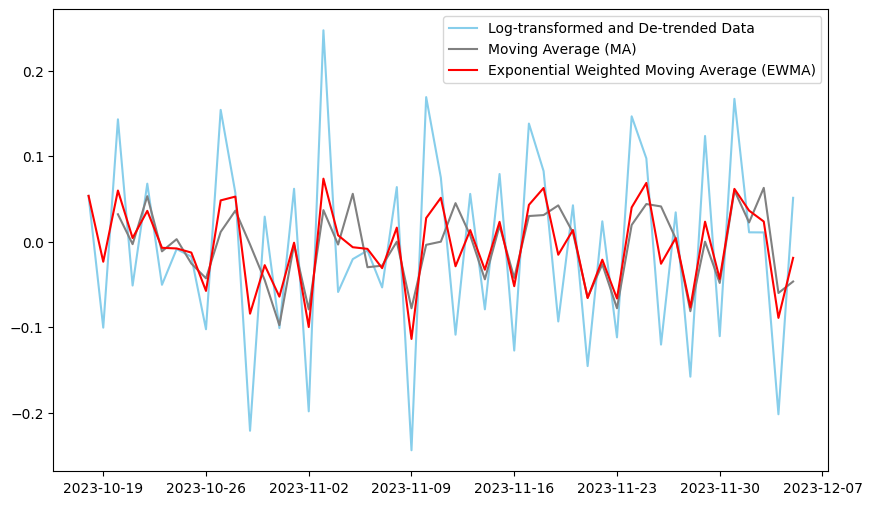

In [40]:
# Estimating MA(12)
ma_lagged_log = log_daily_flights_lagged.rolling(window=3).mean()
# Estimating EWMA(12)
exp_lagged_log = log_daily_flights_lagged.ewm(span=3, adjust=False).mean()
plt.figure(figsize=(10, 6))
# Plotting the log-transformed and de-trended dataset
plt.plot(log_daily_flights_lagged, color='skyblue',label='Log-transformed and De-trended Data')
# Plotting MA curve
plt.plot(ma_lagged_log, color='gray', label='Moving Average (MA)')
# Plotting EWMA curve
plt.plot(exp_lagged_log, color='red', label='Exponential Weighted Moving Average (EWMA)')
# Adding legend
plt.legend()

# Set the locator for the x-axis to show every 7 days
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Show the plot
plt.show()


Log-transformed and De-trended Data represents the original data after it has been log-transformed and de-trended. The log transformation is typically used to stabilize the variance across time, and de-trending removes any underlying trend within the data. The fluctuations around zero suggest that the data might be stationary, which is often a requirement for certain types of time-series analysis.

Moving Average represents the simple moving average of the log-transformed and de-trended data over a specified window. The moving average smooths out the data to help identify the underlying trend.

Exponential Weighted Moving Average represents the exponential weighted moving average, which also smooths the data but gives more weight to the most recent observations. This line follows blue line closely and reacts more quickly to recent changes in the data due to its weighting.

Again EWMA preforms closer to the actual one than MA.

Overall, the graph is used to identify the central tendency over time and to smooth out short-term fluctuations to better analyze long-term trends.

### Dickey-Fuller test

Dickey Fuller test is a statistical test that is used to check for stationarity in time series. This is a type of unit root test, through which we find if the time series is having any unit root.

Unit root is a feature of time series that indicates if there is any stochastic trend in the time series that drives it away from its mean value. Presence of unit root makes a time series non-stationary and as a result it leads to difficulties in deriving statistical inferences from the time series and future predictions.

The H0 hypothesis of the test is that series is non-stationary, while the alternative hypothesis is stationarity. The large p-value suggest that we fail to reject H0, which concludes that the series is non-stationary.

In [41]:
# Perform the ADF test on the time series data
stationarity_test = adfuller(log_daily_flights_lagged.squeeze())

# Print the results of the test
print(stationarity_test)

(-2.1084465917538506, 0.24113177702426158, 8, 40, {'1%': -3.6055648906249997, '5%': -2.937069375, '10%': -2.606985625}, -92.24169436417878)


In [42]:
# get the p value
print(stationarity_test[1])

0.24113177702426158


In order to reject the H0 hypothesis (i.e. to have a stationary series) given 95% confidence interval, one should have the p-value < 0.05 (which is not the case here).

The p-value is 0.3242, which is higher than the common alpha level of 0.05. This means that we fail to reject the null hypothesis. Therefore, the time series data in log_daily_flights_lagged is non-stationary.

In [43]:
# perform the test on the "Passengers" column of the dataset
# save the results in a new variable
stationarity_test_lag = adfuller(log_daily_flights_lagged.squeeze(), maxlag=5)
# print the values of the test
print(stationarity_test_lag)

(-7.5676855112541475, 2.8964155677791885e-11, 5, 43, {'1%': -3.5925042342183704, '5%': -2.931549768951162, '10%': -2.60406594375338}, -90.85351344478204)


The maxlag parameter specifies the maximum number of lags to be used in the ADF regression. This is essentially the number of past values in the time series that the test considers when checking for stationarity.

The choice of lag length can affect the test statistic and the resulting p-value. A higher number of lags can capture more complex autocorrelation structures in the data, which might lead to a more accurate assessment of stationarity. 

However, too many lags can also reduce the power of the test (the ability to correctly reject the null hypothesis when it is false). 

And because of that the test statistic is far below the critical values, and the p-value is 0.0, which is much lower than 0.05. This suggests that we can reject the null hypothesis, indicating that the log_data_lagged time series is stationary.

In [44]:
# perform the test on the "Passengers" column of the dataset
# save the results in a new variable
stationarity_test = adfuller(daily_flights.squeeze())
# print the values of the test
print(stationarity_test)

(-2.328963986491222, 0.16279657362021083, 8, 41, {'1%': -3.60098336718852, '5%': -2.9351348158036012, '10%': -2.6059629803688282}, 239.3351112582901)


The p-value is 0.1585, which is greater than 0.05. Hence, we fail to reject the null hypothesis, suggesting that the daily_flights time series is non-stationary.

# Plotting PACF and ACF to determing p and q*

Here we transform our date and time into a combined datetime format, and aggregate the data to count the number of flights for each hour of every day.

In [45]:

data = pd.read_csv('merged_data.csv')

# Convert 'Date' and 'Time' to datetime
data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])

# Extract the hour and date components
data['Hour'] = data['DateTime'].dt.hour
data['DateHour'] = data['DateTime'].dt.strftime('%Y-%m-%d %H:00:00')

# Group by 'DateHour' and count the number of flights for each hour of every day
data = data.groupby(['DateHour']).size().reset_index(name='Flights')

data['Flights'] = pd.to_numeric(data['Flights'], errors='coerce')
data.set_index('DateHour', inplace=True)
# Display information about the DataFrame
data.info()

# Display the first 5 observations of the DataFrame
data.head()


<class 'pandas.core.frame.DataFrame'>
Index: 1172 entries, 2023-10-17 00:00:00 to 2023-12-05 23:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Flights  1172 non-null   int64
dtypes: int64(1)
memory usage: 18.3+ KB


,Flights
DateHour,
2023-10-17 00:00:00,4
2023-10-17 01:00:00,4
2023-10-17 02:00:00,3
2023-10-17 03:00:00,4
2023-10-17 04:00:00,4


Here we bring data to logarithmic scale and calculate the changes between consecutive time periods, aslo remove any resulting missing values.

In [46]:
# apply logarithmic transformation to the dataset
log_data = np.log(data)

# calculate the one-period difference
log_data_lagged = log_data - log_data.shift()
# drop the missing values (the very first row, as it has no value because of differencing)
log_data_lagged.dropna(inplace=True)
log_data_lagged

,Flights
DateHour,
2023-10-17 01:00:00,0.000000
2023-10-17 02:00:00,-0.287682
2023-10-17 03:00:00,0.287682
2023-10-17 04:00:00,0.000000
2023-10-17 05:00:00,0.000000
...,...
2023-12-05 19:00:00,0.287682
2023-12-05 20:00:00,0.223144
2023-12-05 21:00:00,0.470004


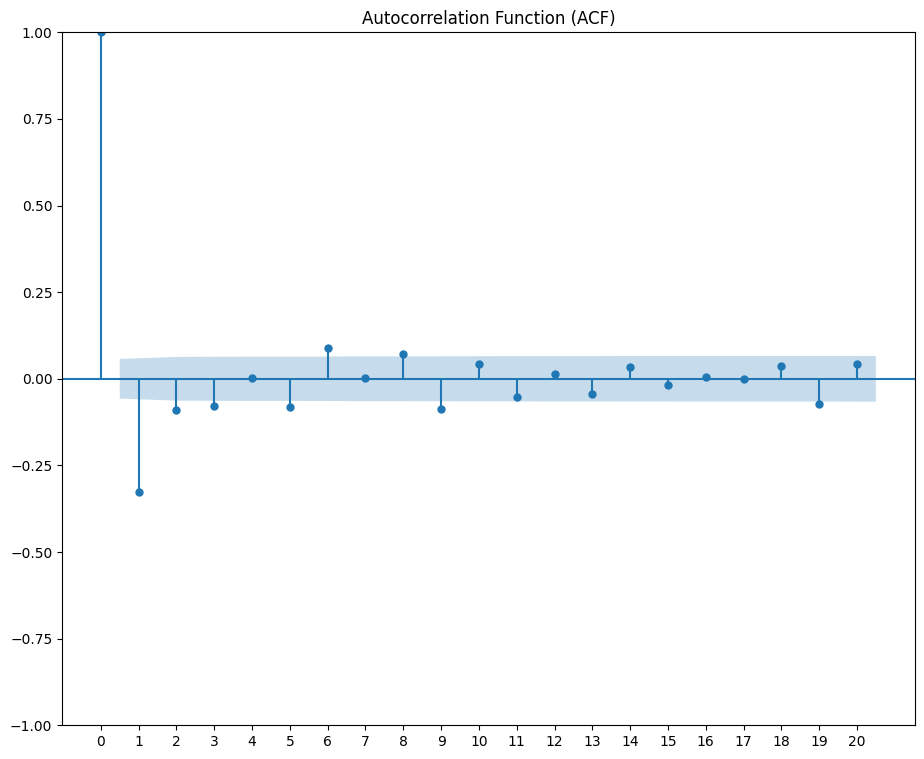

In [47]:
# Plot ACF of log and lagged data
fig, ax = plt.subplots()
plot_acf(log_data_lagged, lags=20, ax=ax)
ax.set_title('Autocorrelation Function (ACF)')
ax.set_xticks(np.arange(0, 21, 1))  # Adjust the range based on your data
plt.show()

The Autocorrelation Function (ACF) plot for a dataset with log-transformed and lagged values displays how the data points correlate with themselves. The ACF plot, with blue markers, visually indicates the correlation strength at each lag and can reveal any periodicity or trend.

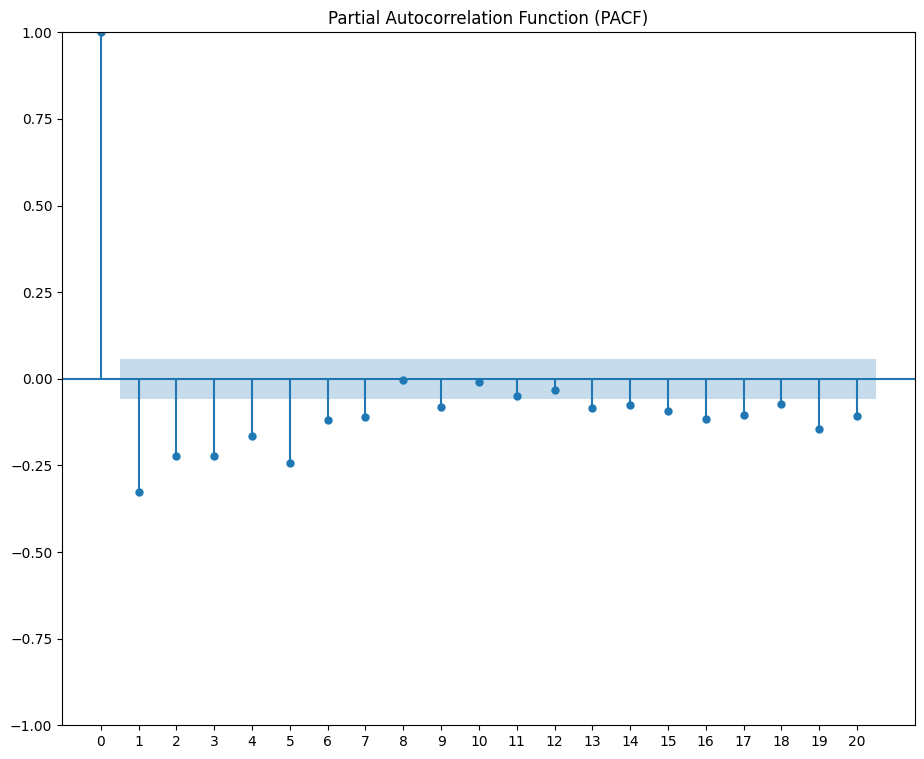

In [48]:
# Plot PACF of log and lagged data
fig, ax = plt.subplots()
plot_pacf(log_data_lagged, lags=20, ax=ax)
ax.set_title('Partial Autocorrelation Function (PACF)')
ax.set_xticks(np.arange(0, 21, 1))  # Adjust the range based on your data
plt.show()

The Partial Autocorrelation Function (PACF) plot shows the direct correlation of a time series with its lags, excluding the influence of earlier lags. The plot is particularly useful in identifying the order of autoregressive terms in time series modeling, indicated by significant spikes in the PACF at specific lags.

# Applying ARIMA model

Here we fit an ARIMA model to a time series dataset.

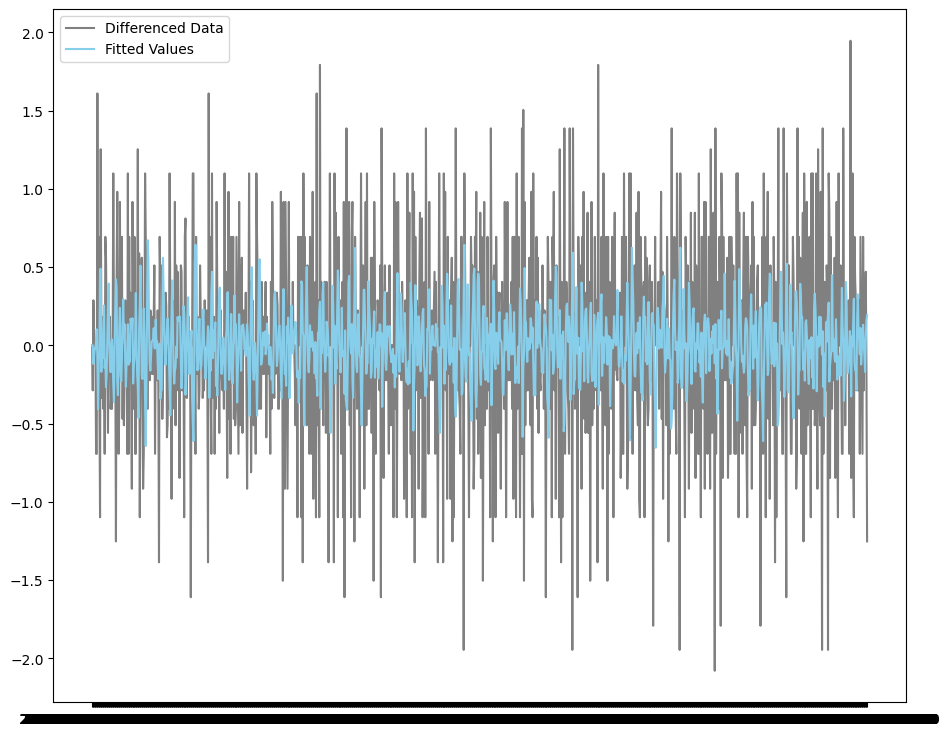

In [49]:
from statsmodels.tsa.arima.model import ARIMA
# Fit ARIMA model with differenced data
model = ARIMA(log_data_lagged, order=(4, 1, 0))
results_AR = model.fit()  # Use disp=False to suppress output

# Plot the differenced data and fitted values
plt.plot(log_data_lagged, label='Differenced Data', color = "gray")
plt.plot(results_AR.fittedvalues, color='skyblue', label='Fitted Values')
plt.legend()
plt.show()

The ARIMA model with parameters (4, 1, 0) to analyzes a log-transformed and once-differenced time series dataset. After fitting the model, it creates a plot that overlays the model's fitted values (in blue) on top of the original differenced data (in gray), allowing for a visual comparison to assess how well the ARIMA model's predictions align with the actual data's fluctuations.

Now we create a Moving Average model for a time series dataset.

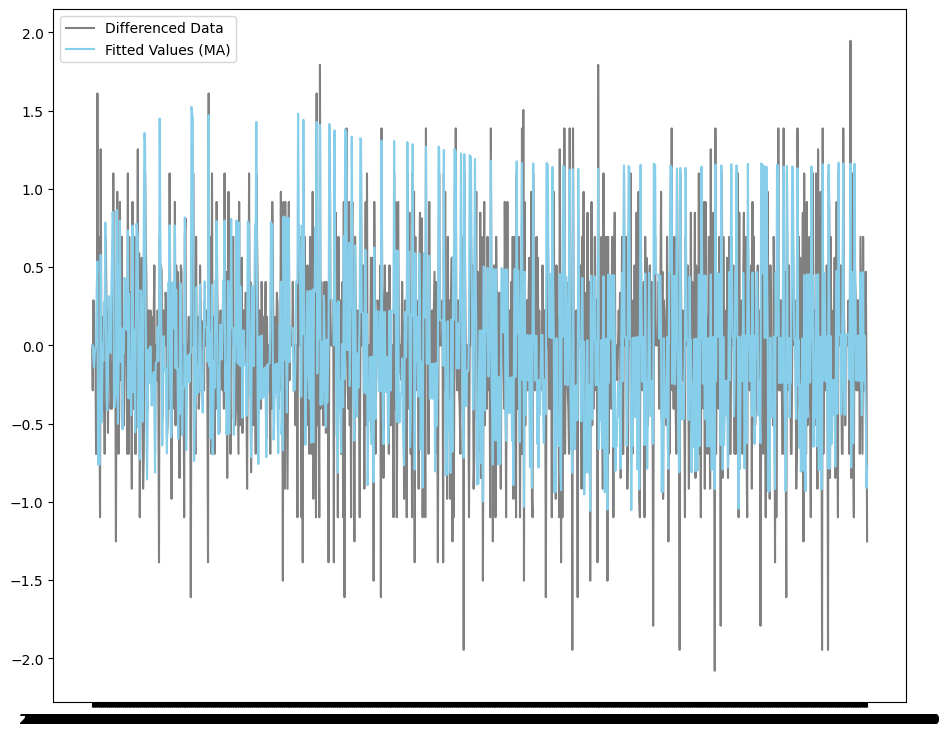

In [50]:
model = ARIMA(log_data_lagged, order=(0, 1, 2))
results_MA = model.fit()  

# Plot the original data and the fitted values
plt.plot(log_data_lagged, label='Differenced Data', color = "gray")
plt.plot(results_MA.fittedvalues, color='skyblue', label='Fitted Values (MA)')
plt.legend()
plt.show()

The ARIMA model with no autoregressive terms, one level of differencing, and two moving average terms is on log-transformed, lagged time series data. It then plots this original data along with the model's fitted values to visually assess how well the Moving Average model captures the data's behavior. The log-transformed, lagged data is plotted in gray, and the Moving Average fitted values are plotted in blue.

Here we fit an ARIMA model to a time series dataset with specific parameters (4, 1, 4).

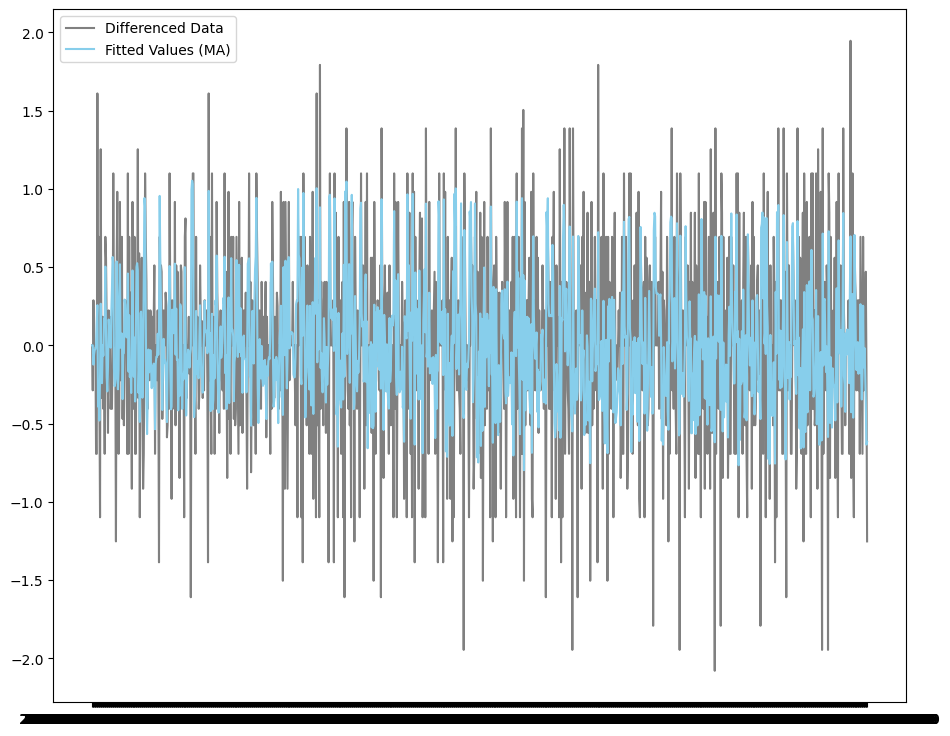

In [51]:
model = ARIMA(log_data_lagged, order=(4, 1, 4))  
results_ARIMA = model.fit()  
plt.plot(log_data_lagged,  label='Differenced Data', color = "gray")
plt.plot(results_ARIMA.fittedvalues, color='skyblue', label='Fitted Values (MA)')
plt.legend()
plt.show()

 Now we plot the log-transformed, lagged data data against the model's fitted values. The plot helps us visually evaluate how closely the model's predictions align with the actual data.

Here we extract the predicted values from the fitted ARIMA model and we store them to use it afterwards.

In [52]:
predictions_log_lag = results_ARIMA.fittedvalues
predictions_log_lag

DateHour
2023-10-17 01:00:00    0.000000
2023-10-17 02:00:00    0.000000
2023-10-17 03:00:00   -0.123177
2023-10-17 04:00:00   -0.058620
2023-10-17 05:00:00   -0.029178
                         ...   
2023-12-05 19:00:00   -0.016872
2023-12-05 20:00:00   -0.158344
2023-12-05 21:00:00   -0.358641
2023-12-05 22:00:00   -0.634152
2023-12-05 23:00:00   -0.616338
Length: 1171, dtype: float64

Here we reverse the differencing of the ARIMA model's predictions. For that we calculate their cumulative sum, so that we can compare them with the original data scale.

In [53]:
# To undo the differencing (shifting) we have to calculate the cumulative sum
predictions_almost_log = predictions_log_lag.cumsum()
predictions_almost_log

DateHour
2023-10-17 01:00:00    0.000000
2023-10-17 02:00:00    0.000000
2023-10-17 03:00:00   -0.123177
2023-10-17 04:00:00   -0.181797
2023-10-17 05:00:00   -0.210975
                         ...   
2023-12-05 19:00:00   -1.936725
2023-12-05 20:00:00   -2.095069
2023-12-05 21:00:00   -2.453709
2023-12-05 22:00:00   -3.087861
2023-12-05 23:00:00   -3.704200
Length: 1171, dtype: float64

Here we transform the data into a DataFrame and we name its column "Flights".

In [54]:
# Convert this series to DataFrame
predictions_almost_log = pd.Series.to_frame(predictions_almost_log)
predictions_almost_log.columns=["Flights"]
predictions_almost_log

,Flights
DateHour,
2023-10-17 01:00:00,0.000000
2023-10-17 02:00:00,0.000000
2023-10-17 03:00:00,-0.123177
2023-10-17 04:00:00,-0.181797
2023-10-17 05:00:00,-0.210975
...,...
2023-12-05 19:00:00,-1.936725
2023-12-05 20:00:00,-2.095069
2023-12-05 21:00:00,-2.453709


In [55]:
print(log_data.iloc[3])

Flights    1.386294
Name: 2023-10-17 03:00:00, dtype: float64


In [56]:
# add that value to all rows
predictions_almost_log = predictions_almost_log + log_data.iloc[0]
# show first 5 observations
predictions_almost_log.head()

,Flights
DateHour,
2023-10-17 01:00:00,1.386294
2023-10-17 02:00:00,1.386294
2023-10-17 03:00:00,1.263117
2023-10-17 04:00:00,1.204497
2023-10-17 05:00:00,1.175319


In [57]:
predictions_log = pd.concat([log_data_lagged[0:1],predictions_almost_log])
# Show first 5 observations after concatination
predictions_log.head()

,Flights
DateHour,
2023-10-17 01:00:00,0.000000
2023-10-17 01:00:00,1.386294
2023-10-17 02:00:00,1.386294
2023-10-17 03:00:00,1.263117
2023-10-17 04:00:00,1.204497


In [58]:
predictions = np.exp(predictions_log)
# show first 5 observations
print(predictions)

                      Flights
DateHour                     
2023-10-17 01:00:00  1.000000
2023-10-17 01:00:00  4.000000
2023-10-17 02:00:00  4.000000
2023-10-17 03:00:00  3.536429
2023-10-17 04:00:00  3.335081
...                       ...
2023-12-05 19:00:00  0.576702
2023-12-05 20:00:00  0.492247
2023-12-05 21:00:00  0.343896
2023-12-05 22:00:00  0.182397
2023-12-05 23:00:00  0.098480

[1172 rows x 1 columns]


Here we create a visual table to show the first 15 entries from the of "predictions".

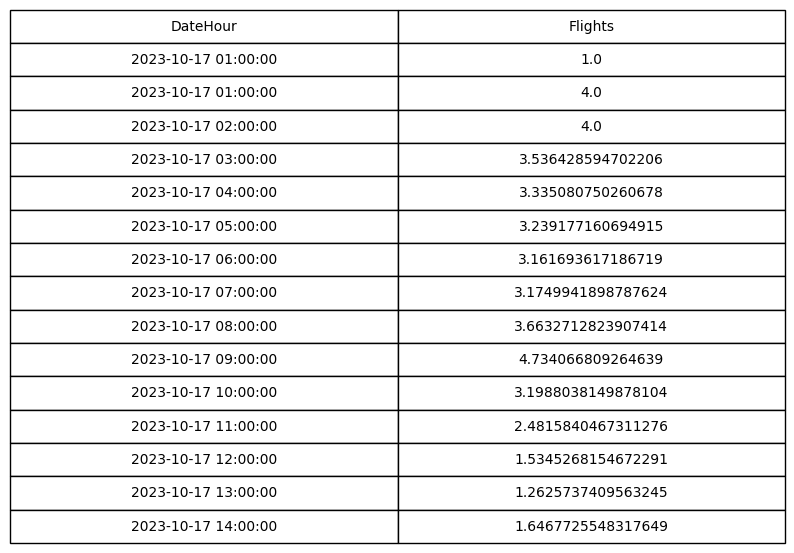

In [59]:
table_data = predictions.head(15).reset_index()

# Creating a table to display the predictions
fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('off')  # Turn off the axis

# Creating the table
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, cellLoc='center', loc='center')

# Styling the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)  # Adjust the scaling based on your preference

plt.show()


In [60]:
results_ARIMA.plot_predict(1,264) 

AttributeError: 'ARIMAResults' object has no attribute 'plot_predict'